# Miami DS Meet-Up August 19th, 2020
## Overview

In this session, we will be "Building Advanced Image Classifiers with PyTorch".  We will build an image classifier that will be able to detect 5 different types of flowers using an actual vision dataset from Kaggle:

https://www.kaggle.com/alxmamaev/flowers-recognition 

The dataset contains 4242 images across 5 difference classes.   For those of you that want to follow along with Colab, there is a slightly smaller flower dataset you will load.

## Session Agenda
1.  Review deep learning basics
2.  Understand CNN components and why they work
3.  Code a simple CNN model from scratch
4.  Build a state of the art classifier using a pre-trained network

## Setting Up Your Environment
You have 3 options to follow along.  If you have a GPU on your laptop/desktop, you can load the libraries and dataset locally and run the notebook locally.   Otherwise, you can choose to run the notebook (free) in Google Colab.  Note, it is not required that you run the notebook to attend the session but it will help you understand the content.

### Option 1 - Setup your own laptop/PC with GPU for this workbook

If you have a GPU and want to work on your own laptop/PC:

1.  Download the dataset from Kaggle (https://www.kaggle.com/alxmamaev/flowers-recognition) and unzip the dataset on your local drive
2.  Download Anaconda  (https://www.anaconda.com/distribution/)
3.  Create a virtual environment using Anaconda on your local machine by following these commands:

```
conda create --name MiamiData2020 python=3.8
conda activate MiamiData2020
conda install pytorch torchvision cudatoolkit=10.2 -c pytorch
conda install matplotlib jupyter
conda install -c intel scikit-learn
pip install efficientnet_pytorch
pip install torchsummary
python -m ipykernel install --user --name MiamiData2020 --display-name "MiamiData2020"
git clone https://github.com/jacobffjensen/MiamiDS2020June
jupyter notebook
```

4. Skip Option 2 below and deactivate the first code cell of the notebook by selecting it and typing "R" (intended for Colab only)
5. Specify the directory of your dataset in the 2nd cell below.

### Option 2 - Follow along in a Google Colab workbook

If you want to work in Google Colab, into Colab and pull the notebook file from GitHub:
1.  Go to colab.research.google.com
2.  Click **GitHub** and paste the address **https://github.com/jacobffjensen/MiamiDS2020June**
3.  Click **Search Icon**
4.  Click on **MiamiDSMeetupJune2020.ipynb**, notebook should now open
5.  Set the notebook settings to **Python** and **GPU** (**Edit -> Notebook Settings**) 

Then, we will load the dataset into Colab by executing the first cell (click the cell, then click **crtl+enter**).

### Option 3 - Just follow along during the presentation
Running the notebook is not required to get something out of the session :)

In [1]:
data_dir = "C:\\datasets\\kaggleflower\\flowers\\"  # my local drive
#data_dir = "/content/flower_photos/" # Colab directory

# Part 2 - Loading the Libraries and Checking Environment

In [2]:
# Load the appropiate PyTorch libraries and visualization libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Subset
import matplotlib.pyplot as plt
import numpy as np
import random
import time

In [3]:
# Setup our notebook to be able to regenertate results
SEED = 4321
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
np.random.seed(SEED)

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print ("GPU is availble!" if use_cuda else "No GPU :(")
print (torch.cuda.get_device_name(0) if use_cuda else None)
print (torch.__version__)

GPU is availble!
GeForce GTX 1080
1.6.0


# Part 3 - Load our Dataset and Analyze It
Next, we will load our dataset using PyTorch's built in command that will load pictures from a directory using the subfolder names as the labels.


In [5]:
# Normalize our images with the ImageNet means and stdev
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], 
    std=[0.229, 0.224, 0.225])

# Undo our noramlization for display purposes
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225])

# Augment our training data every time we grab a batch
trans = transforms.Compose([transforms.RandomRotation(25),
                                  transforms.RandomResizedCrop(224),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.ToTensor(),
                                  normalize])

# For validation and testing dataset (no data augmentation)
transNoAugment = transforms.Compose([transforms.Resize(224), 
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     normalize])

In [6]:
# Create datasets using ImageFolder which will use 
# foldernames to populate labels
fullDataAug = datasets.ImageFolder(data_dir, transform=trans)
fullDataNoAug = datasets.ImageFolder(data_dir, transform=transNoAugment)

# Save the class labels for later
classes=fullDataAug.classes

# Create the index splits for training, validation and test
total = len(fullDataAug)
indices = list(range(total))

# Grab 80% of the data for training, then 10% / 10% for test and validation
trainingPercent = .8
split1 = int(total*trainingPercent)
split2 = int(((total - split1)/2)+split1)
np.random.shuffle(indices)

# Build datasets by using Subset and pass the split indices
traindata = Subset(fullDataAug, indices[:split1])
valdata = Subset(fullDataNoAug, indices[split1:split2])
testdata = Subset(fullDataNoAug, indices[split2:])

In [7]:
# Print out the classes and association found by ImageFolder
print(fullDataAug.class_to_idx)

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}


In [8]:
# Analyze the dataset by checking the balance of the labels
@torch.no_grad() 
def labelDistribution(dataset, classes, setName):
    num_classes = len(classes)
    labels = torch.zeros(num_classes, dtype=torch.long)
    for _, target in dataset:
        labels[target] += 1
    print ('------- {} ({}) ------- '.format(setName,labels.sum()))
    for idx, name in enumerate(classes):
        print ('{} {} ({:0.1f}%)'.format(labels[idx], name, labels[idx].float()/labels.sum()*100))
    print("\n")

labelDistribution(traindata,classes,"Train")
labelDistribution(valdata,classes,"Validation")
labelDistribution(testdata,classes,"Testing")

------- Train (3458) ------- 
612 daisy (17.7%)
851 dandelion (24.6%)
616 rose (17.8%)
601 sunflower (17.4%)
778 tulip (22.5%)


------- Validation (432) ------- 
79 daisy (18.3%)
101 dandelion (23.4%)
83 rose (19.2%)
62 sunflower (14.4%)
107 tulip (24.8%)


------- Testing (433) ------- 
78 daisy (18.0%)
100 dandelion (23.1%)
85 rose (19.6%)
71 sunflower (16.4%)
99 tulip (22.9%)




# Compare Original vs. Augmented Images
Here we will take a closer look at how the images are modified by the transform.  You can replay this and see the changes made to the image.  Note, both images have been normalized to the ImageNet mean/stdev so their colors are modified a bit from the original.

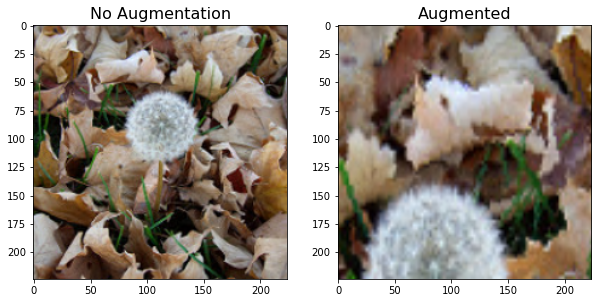

In [9]:
def compareImg2Img(img1,img2):
    fontsz = 16
    img1 = inv_normalize(img1)
    img2 = inv_normalize(img2)
    
    img1 = img1.numpy()
    img1 = np.transpose(img1, (1, 2, 0))
    img2 = img2.numpy()
    img2 = np.transpose(img2, (1, 2, 0))

    f, ax = plt.subplots(1, 2, figsize=(10, 10))

    ax[0].imshow(img1, cmap='gray')
    ax[1].imshow(img2,cmap='gray')
    ax[0].set_title('No Augmentation', fontsize=fontsz)
    ax[1].set_title('Augmented', fontsize=fontsz)

compareImg2Img(fullDataNoAug[traindata.indices[10]][0],traindata[10][0])

# Create the DataLoaders for Train, Validation and Test
Lets split our dataset into test, train and validation sets using about 80% of our dataset for training.

In [10]:
num_workers = 4
batch_size = 32

trainLoader = torch.utils.data.DataLoader(traindata, batch_size=batch_size, 
                                          num_workers=num_workers, 
                                          drop_last=True, shuffle=True)

valLoader = torch.utils.data.DataLoader(valdata, batch_size=batch_size,
                                        num_workers=num_workers, 
                                        drop_last=True)

testLoader = torch.utils.data.DataLoader(testdata, batch_size=batch_size, 
                                         num_workers=num_workers, 
                                         drop_last=True)

In [11]:
# Check out the first batch of labels and ensure they are shuffled
x,y = next(iter(trainLoader))
print (y)

tensor([3, 1, 1, 3, 1, 4, 0, 2, 2, 3, 1, 4, 4, 1, 0, 4, 3, 3, 4, 4, 1, 1, 0, 4,
        2, 4, 3, 3, 1, 3, 2, 4])


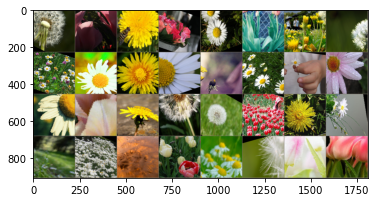

dandelion tulip dandelion  rose daisy tulip dandelion dandelion daisy daisy dandelion daisy dandelion daisy daisy daisy daisy tulip dandelion dandelion dandelion tulip dandelion daisy daisy daisy dandelion tulip daisy dandelion tulip tulip


In [12]:
#https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def imshow(img):
    img = inv_normalize(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

images, labels = iter(trainLoader).next()
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(32)))

# Build the Testing and Validation Code

In [13]:
# calculate our validation loss and accuracy
@torch.no_grad() 
def scoreModel(loader, criterion, model, device, name):
    model.eval()
    lossTotal = 0.0
    numCorrect = 0

    for x,y in loader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = criterion(pred, y)
        lossTotal+=loss.item()
        
        predClass = pred.max(1)[1] # grab largest logit index of the 5 converting [32,5] to [32]
        numCorrect+=((predClass==y).sum())
    
    lossAvg = lossTotal/len(loader)
    acc = numCorrect.float()/x.size(0)/len(loader)*100

    print('{} Loss {:0.2f}  Accuracy: {:0.2f}%  '.format(name,lossAvg,acc),end='')
    
    return lossAvg

In [14]:
# Train our model - train and save the best model in fileName
def trainModel(model, trainLoader, criterion, optimizer, fileName, epochs = 5):

    tStart = time.time()
    v_loss = float('inf')  
    for epoch in range(epochs):
        t_loss = 0  
        model.train()

        for x, y in trainLoader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            pred = model(x)
            loss = criterion(pred,y)
            loss.backward()
            optimizer.step()

            t_loss += loss.item()  # Average loss over batch

        # Compute the final training loss after a full epoch
        finalLoss = t_loss / len(trainLoader)
        print ('{} / {} Training Loss {:0.2f}  '.format(epoch+1,epochs,finalLoss), end='')

        # Check the validation loss and save the model only if its decreased
        loss = scoreModel(valLoader, criterion, model, device, "Validation")
        if (v_loss>loss):
            torch.save(model.state_dict(), fileName)
            print ("  Saving model...", end='')
            v_loss = loss
        print ("\n")
    print ("Training Time: {:0.2f} seconds".format(time.time()-tStart))

# Build a Simple Model with 5 Classes


In [15]:
# A simple network using convolutions and batchnorm
class JacobNet(nn.Module):
    def __init__(self):
        
        super(JacobNet, self).__init__()
        self.c1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.c11 = nn.Conv2d(32,32,3, padding=1)
        self.bn11 = nn.BatchNorm2d(32)

        self.c2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.c22 = nn.Conv2d(64,64,3, padding=1)
        self.bn22 = nn.BatchNorm2d(64)
             
        self.c3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.c33 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn33 = nn.BatchNorm2d(128)
        
        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.pool3 = nn.MaxPool2d(4, 4)
        
        self.fc1 = nn.Linear(128*14*14, 50)
        self.fc2 = nn.Linear(50, 5)
        
    def forward(self, x):
        # 3 x 224 x 224        
        x = F.relu(self.bn1(self.c1(x)))
        x = self.pool1(F.relu(self.bn11((self.c11(x)))))

        # 32 x 112 x 112
        x = F.relu(self.bn2(self.c2(x)))
        x = self.pool2(F.relu(self.bn22((self.c22(x)))))

        # 64 x 56 x 56
        x = F.relu(self.bn3(self.c3(x)))
        x = self.pool3(F.relu(self.bn33((self.c33(x)))))
        
        # 128 x 14 x 14        
        x = x.view(-1, 128*14*14)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = JacobNet()    
model = model.to(device)

# Define our loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001,momentum=0.9)

# View the summary
from torchsummary import summary
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
            Conv2d-3         [-1, 32, 224, 224]           9,248
       BatchNorm2d-4         [-1, 32, 224, 224]              64
         MaxPool2d-5         [-1, 32, 112, 112]               0
            Conv2d-6         [-1, 64, 112, 112]          18,496
       BatchNorm2d-7         [-1, 64, 112, 112]             128
            Conv2d-8         [-1, 64, 112, 112]          36,928
       BatchNorm2d-9         [-1, 64, 112, 112]             128
        MaxPool2d-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 128, 56, 56]          73,856
      BatchNorm2d-12          [-1, 128, 56, 56]             256
           Conv2d-13          [-1, 128, 56, 56]         147,584
      BatchNorm2d-14          [-1, 128,

In [16]:
trainModel(model, trainLoader,criterion, optimizer, "bestflower.pt")
model.load_state_dict(torch.load("bestflower.pt"))
scoreModel(testLoader, criterion, model, device, "Testing")

1 / 5 Training Loss 1.31  Validation Loss 1.12  Accuracy: 53.85%    Saving model...

2 / 5 Training Loss 1.13  Validation Loss 0.99  Accuracy: 58.89%    Saving model...

3 / 5 Training Loss 1.04  Validation Loss 1.00  Accuracy: 59.13%  

4 / 5 Training Loss 1.03  Validation Loss 1.04  Accuracy: 56.97%  

5 / 5 Training Loss 0.97  Validation Loss 0.90  Accuracy: 64.66%    Saving model...

Training Time: 125.87 seconds
Testing Loss 0.97  Accuracy: 61.30%  

0.9675091459200933

# Build a Model with 5 Classes using a Pre-Trained Model (ResNet 50)
Here we will use ResNet50 with pre-trained weights and replace the last layer with a new classifer

In [17]:
# Start by loading the Resnet50 model with pre-trained weights
model = models.resnet50(pretrained=True)

# Freeze the model weights keeping only FC trainable
# Decided to fine tune entire model instead
for param in model.parameters():
    param.requires_grad = False

# Build new FC layer
from collections import OrderedDict
model.fc = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 500)),
                          ('relu', nn.ReLU()),
                          ('drop1', nn.Dropout(0.25)),
                          ('fc2', nn.Linear(500, 5)),
                          ]))

# Push model to GPU if we have one
model = model.to(device)

# Define our loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [18]:
trainModel(model, trainLoader, criterion, optimizer, "bestflowerresnet.pt")
model.load_state_dict(torch.load("bestflowerresnet.pt"))
scoreModel(testLoader, criterion, model, device, "Testing")

1 / 5 Training Loss 1.35  Validation Loss 0.96  Accuracy: 77.88%    Saving model...

2 / 5 Training Loss 0.85  Validation Loss 0.59  Accuracy: 84.13%    Saving model...

3 / 5 Training Loss 0.65  Validation Loss 0.48  Accuracy: 83.17%    Saving model...

4 / 5 Training Loss 0.57  Validation Loss 0.40  Accuracy: 88.70%    Saving model...

5 / 5 Training Loss 0.53  Validation Loss 0.39  Accuracy: 86.30%    Saving model...

Training Time: 89.49 seconds
Testing Loss 0.41  Accuracy: 85.10%  

0.4069066013281162

# Build a Model with 5 Classes using a Pre-Trained Model (EfficientNet-B0)

In [19]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=5)
model = model.to(device)

# Define our loss and optimizer and then fine tune
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.0002)

Loaded pretrained weights for efficientnet-b0


In [20]:
trainModel(model, trainLoader, criterion, optimizer, "bestflowerenet.pt")
model.load_state_dict(torch.load("bestflowerenet.pt"))
scoreModel(testLoader, criterion, model, device, "Testing")

1 / 5 Training Loss 0.51  Validation Loss 0.22  Accuracy: 92.31%    Saving model...

2 / 5 Training Loss 0.30  Validation Loss 0.20  Accuracy: 92.79%    Saving model...

3 / 5 Training Loss 0.27  Validation Loss 0.17  Accuracy: 94.71%    Saving model...

4 / 5 Training Loss 0.24  Validation Loss 0.17  Accuracy: 94.23%  

5 / 5 Training Loss 0.21  Validation Loss 0.13  Accuracy: 95.43%    Saving model...

Training Time: 167.00 seconds
Testing Loss 0.15  Accuracy: 94.23%  

0.15138841463396183

# Analyze the Model's Performance

In [21]:
# Adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
%matplotlib inline  
import sklearn
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time

@torch.no_grad()
def confusion(loader, model):
    preds = torch.tensor([], dtype=torch.float, device=device)
    labels = torch.tensor([],dtype=torch.long, device=device)
    model.eval()
    for x,y in loader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        preds = torch.cat((preds, pred), dim=0)
        labels = torch.cat((labels,y), dim=0)

    preds = preds.argmax(dim=1)
    cm = confusion_matrix(labels.cpu(), preds.cpu())

    # Visualize the confusion matrix using SciKit learn code
    normalize=False
    title='Confusion matrix'
    cmap=plt.cm.Blues
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return preds, labels

Confusion matrix, without normalization


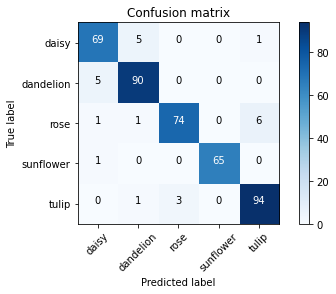

In [22]:
preds, labels = confusion(testLoader, model)

In [23]:
print (fullDataAug.class_to_idx)
preds = preds.cpu()
labels = labels.cpu()
((preds==4) & (labels==2)).sum()

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}


tensor(6)

[ 22  77 189 217 275 401]
2
C:\datasets\kaggleflower\flowers\rose\17869810353_c0d9902bc3_n.jpg


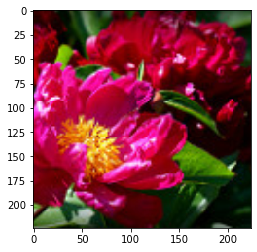

2
C:\datasets\kaggleflower\flowers\rose\8692051081_dffa8709e7_m.jpg


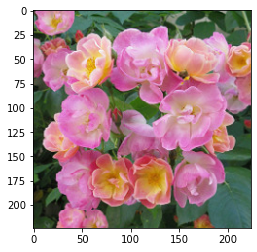

2
C:\datasets\kaggleflower\flowers\rose\3422228549_f147d6e642.jpg


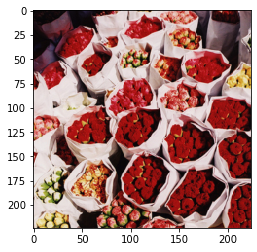

2
C:\datasets\kaggleflower\flowers\rose\2536282942_b5ca27577e.jpg


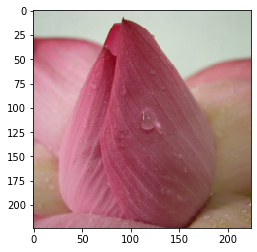

2
C:\datasets\kaggleflower\flowers\rose\15566697073_9a214b700e_n.jpg


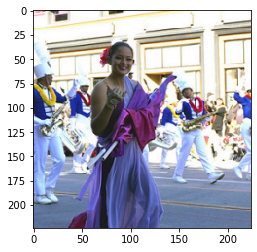

2
C:\datasets\kaggleflower\flowers\rose\18486124712_17ebe7559b_n.jpg


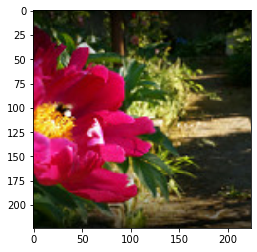

In [24]:
idx = np.argwhere(np.asarray((preds==4) & (labels==2)))
print (idx.squeeze())

def show(oridataset, dataset, idx):
    img = dataset[idx][0]
    img = inv_normalize(img)
    npimg = img.numpy()

    print (fullDataAug.imgs[dataset.indices[idx]][1])
    print (fullDataAug.imgs[dataset.indices[idx]][0])
    
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.show()

%matplotlib inline  
from PIL import Image
for i in idx.squeeze():
    show(fullDataAug, testLoader.dataset,i)

# Clean-up
If using Colab, delete your API token from Kaggle and change your Colab environment back to CPU 